In [41]:
import networkx as nx
import osmnx as ox
from IPython.display import IFrame
import requests
import matplotlib.cm as cm
import matplotlib.colors as colors
%matplotlib inline
ox.config(log_console=True)
ox.__version__

'1.0.1'

In [21]:
import geopandas as gpd
#from shapely.geometry import Point, Polygon, LineString
#from descartes import PolygonPatch
#import shapefile

In [22]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#import seaborn as sns
mpl.rc('font', family='NanumGothic') #한글 폰트 적용시
plt.rcParams["figure.figsize"] = (10,10) #차트 기본 사이즈

# OSMNX (Open Street Map + NetworkX ?)를 이용한 네트워크 분석  

### 개발자 블로그   
https://geoffboeing.com/2016/11/osmnx-python-street-networks/

소스코드  
https://github.com/gboeing/osmnx  
https://pypi.org/project/osmnx/  

### 구현 예제   
https://github.com/gboeing/osmnx-examples/tree/master/notebooks

### 참조 사이트   
https://networkx.org/documentation/stable//index.html

## OSM 경로 데이터 로딩 

### 1. 지명

C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\dhl\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


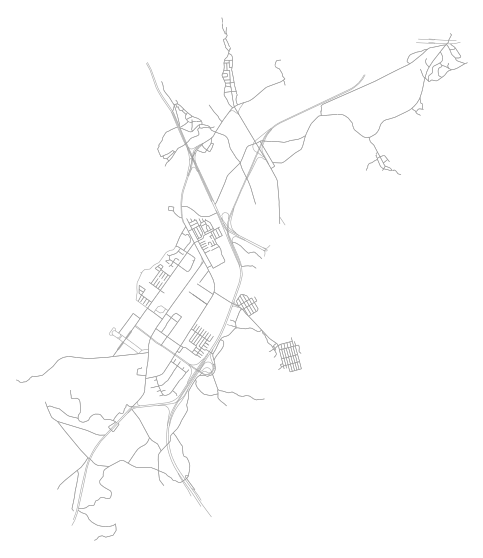

In [257]:
ox.config(log_console=True, use_cache=True)

# get a graph for some city
G = ox.graph_from_place('과천시, 경기도, 대한민국', network_type='drive', simplify=False) #,  buffer_dist=200) 

# /data/파일명 폴더 내의 edges/ nodes폴더에 링크와 노트 shp파일이 저장됨
ox.save_graph_shapefile(G, filepath='./data/osm_road')

fig, ax = ox.plot_graph(G, figsize=(10,10), node_size=0, edge_linewidth=0.5, bgcolor='w')

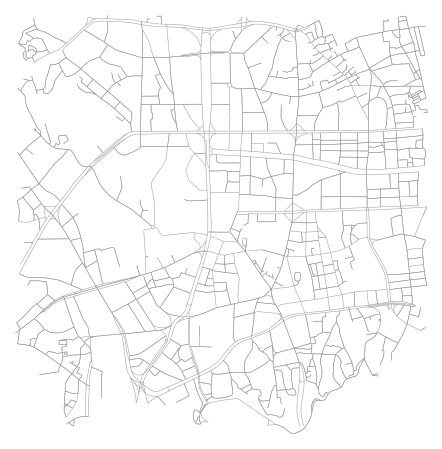

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [256]:
G = ox.graph_from_point((37.5655, 126.9779), dist=1200, network_type='drive_service')  #좌표 반경 범위 
ox.plot_graph(G, node_size=0, edge_linewidth=0.5, bgcolor='w')

OSM 데이터 대상 설정 방법   
- a bounding box  
- a lat-long point plus a distance   
- an address plus a distance   
- a polygon of the desired street network’s boundaries   
- a place name or list of place names   

Network type (network_type)

- ‘drive’ : get drivable public streets (but not service roads)  
- ‘drive_service’ : get drivable public streets, including service roads  
- ‘walk’ : get all streets and paths that pedestrians can use (this network type ignores one-way directionality)  
- ‘bike’ : get all streets and paths that cyclists can use  
- ‘all’ : download all (non-private) OSM streets and paths  
- ‘all_private’ : download all OSM streets and paths, including private-access ones  

## 최단경로 분석 

서소문~광화문

In [160]:
orig_node = ox.get_nearest_node(G, (37.557638657147585, 126.97322081586789)) #서울역 연세세브란스빌딩 앞 
dest_node = ox.get_nearest_node(G, (37.57442565618067, 126.98542855257266))  #인사동 쌈지길 

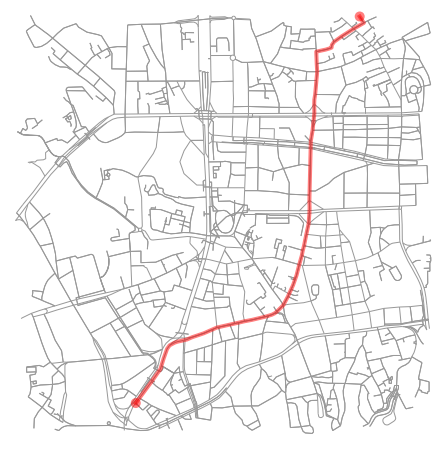

In [187]:
# find the route between these nodes then plot it
route = nx.shortest_path(G, orig_node, dest_node, weight='length')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w' ) #, figsize=(10,10)

## 시간거리 분석

위의 경로는 도형의 길이를 기준으로 하는 최단경로이다.     
OSM 경로 데이터의 타입별로 기준 속도를 부여하고, 이 기준속도와 도형 길이를 가지고 소요시간을 산출하여 최적경로(시간거리)를 구해보자   
시간(분) = (거리(meter) / 속도(시속 / 3.6)) / 60

In [236]:
# impute missing edge speeds then calculate edge travel times
G = ox.add_edge_speeds(G)
# speed_kph 항목을 만들고 maxspeed 값을 부여. maxspeed가 없는 레코드는 highway(도로 종류)별 평균값을 부여 
G = ox.add_edge_travel_times(G)
# travel_time 항목을 만들고 legth / speed_kph 값을 부여 

In [237]:
# you can convert your graph to node and edge GeoPandas GeoDataFrames
gdf_nodes, gdf_edges = ox.graph_to_gdfs(G)
gdf_nodes.head()

,y,x,street_count,highway,geometry
osmid,,,,,
287631232,37.570051,126.972549,4,NaN,POINT (126.97255 37.57005)
287712142,37.574041,126.972691,4,NaN,POINT (126.97269 37.57404)
287712330,37.570189,126.972549,4,NaN,POINT (126.97255 37.57019)
292395181,37.573250,126.985872,3,NaN,POINT (126.98587 37.57325)
292395190,37.572978,126.986233,4,NaN,POINT (126.98623 37.57298)


In [238]:
gdf_edges.head()

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    621513156    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    516417604   False   NaN  NaN  새문안로3길  residential   
287712142 436807109  0     37399752   False     4  NaN   사직로8길  residential   
          4654955159 0    516417604   False   NaN  NaN  새문안로3길  residential   

                         maxspeed   length  speed_kph  travel_time  \
u         v          key                                             
287631232 1936511583 0         60  168.025       60.0         10.1   
          2930525587 0        NaN   73.923       48.7          5.5   
          287712330  0        NaN   15.334       48.7          1.1   
287712142 436807109  0        NaN   65.804       48.7          4.9   
          4654955159 0        NaN  104.631       48.7          7.7   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   
287712142 436807109  0    LINESTRING (126.97269 37.57404, 126.97344 37.5...   
          4654955159 0    LINESTRING (126.97269 37.57404, 126.97265 37.5...   

                         junction bridge access service tunnel  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN     NaN    NaN  
          2930525587 0        NaN    NaN    NaN     NaN    NaN  
          287712330  0        NaN    NaN    NaN     NaN    NaN  
287712142 436807109  0        NaN    NaN    NaN     NaN    NaN  
          4654955159 0        NaN    NaN    NaN     NaN    NaN

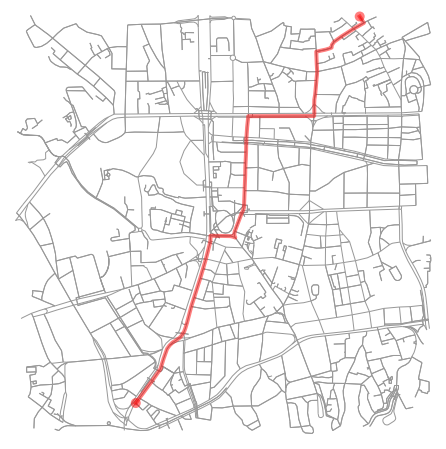

In [186]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G, orig_node, dest_node, weight='travel_time')
fig, ax = ox.plot_graph_route(G, route, node_size=0, bgcolor='w')

In [51]:
filepath = './result/route_map01.html'
route_graph_map = ox.plot_route_folium(G, route, popup_attribute='name', weight=3, color='Red')
route_graph_map.save(filepath)
IFrame(filepath, width=950, height=500)

In [178]:
# 최단거리 분석 결과의 길이를 확인
len = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

2.5 킬로미터


In [216]:
# 시간거리 분석 결과의 길이를 확인
len = nx.shortest_path_length(G, orig_node, dest_node, weight='travel_time') 
print(round(len, 1), "분?") ##포털지도에선 약 10분 전후

162.6 분?


## 도로 등급별 속도 및 소요시간 적용한 시간거리 분석

In [239]:
gdf_edges.head()

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    621513156    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    516417604   False   NaN  NaN  새문안로3길  residential   
287712142 436807109  0     37399752   False     4  NaN   사직로8길  residential   
          4654955159 0    516417604   False   NaN  NaN  새문안로3길  residential   

                         maxspeed   length  speed_kph  travel_time  \
u         v          key                                             
287631232 1936511583 0         60  168.025       60.0         10.1   
          2930525587 0        NaN   73.923       48.7          5.5   
          287712330  0        NaN   15.334       48.7          1.1   
287712142 436807109  0        NaN   65.804       48.7          4.9   
          4654955159 0        NaN  104.631       48.7          7.7   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   
287712142 436807109  0    LINESTRING (126.97269 37.57404, 126.97344 37.5...   
          4654955159 0    LINESTRING (126.97269 37.57404, 126.97265 37.5...   

                         junction bridge access service tunnel  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN     NaN    NaN  
          2930525587 0        NaN    NaN    NaN     NaN    NaN  
          287712330  0        NaN    NaN    NaN     NaN    NaN  
287712142 436807109  0        NaN    NaN    NaN     NaN    NaN  
          4654955159 0        NaN    NaN    NaN     NaN    NaN

In [240]:
def cus_speed(df):
   if (df['highway'] == 'mortorway'):   #고속도로/ 자동차 전용도로
     return 80
   elif (df['highway'] == 'primary'): #국도
     return 55
   elif (df['highway'] == 'secondary'): #지방도, 특광역시도 등
     return 45
   elif (df['highway'] == 'tertiary'): #3차 - 시군도급?
     return 35
   else: #residential, living_street, service, unclassified, road - 이면도로 및 연결로 등
     return 20

In [241]:
gdf_edges['speed_kph'] = gdf_edges.apply(lambda x: cus_speed(x), axis = 1)
gdf_edges.head()

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    621513156    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    516417604   False   NaN  NaN  새문안로3길  residential   
287712142 436807109  0     37399752   False     4  NaN   사직로8길  residential   
          4654955159 0    516417604   False   NaN  NaN  새문안로3길  residential   

                         maxspeed   length  speed_kph  travel_time  \
u         v          key                                             
287631232 1936511583 0         60  168.025         55         10.1   
          2930525587 0        NaN   73.923         20          5.5   
          287712330  0        NaN   15.334         20          1.1   
287712142 436807109  0        NaN   65.804         20          4.9   
          4654955159 0        NaN  104.631         20          7.7   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   
287712142 436807109  0    LINESTRING (126.97269 37.57404, 126.97344 37.5...   
          4654955159 0    LINESTRING (126.97269 37.57404, 126.97265 37.5...   

                         junction bridge access service tunnel  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN     NaN    NaN  
          2930525587 0        NaN    NaN    NaN     NaN    NaN  
          287712330  0        NaN    NaN    NaN     NaN    NaN  
287712142 436807109  0        NaN    NaN    NaN     NaN    NaN  
          4654955159 0        NaN    NaN    NaN     NaN    NaN

In [243]:
# 시간(분) = 거리(미터) / (시속 / 3.6)  / 60
gdf_edges['travel_time'] = gdf_edges.apply(lambda x: (gdf_edges['length'] / (gdf_edges['speed_kph'] / 3.6) / 60), axis = 1)
gdf_edges.head()

osmid  oneway lanes  ref    name      highway  \
u         v          key                                                      
287631232 1936511583 0    621513156    True     4    6    새문안로      primary   
          2930525587 0    180793307   False   NaN  NaN    새문안로  residential   
          287712330  0    516417604   False   NaN  NaN  새문안로3길  residential   
287712142 436807109  0     37399752   False     4  NaN   사직로8길  residential   
          4654955159 0    516417604   False   NaN  NaN  새문안로3길  residential   

                         maxspeed   length  speed_kph  travel_time  \
u         v          key                                             
287631232 1936511583 0         60  168.025         55       0.1833   
          2930525587 0        NaN   73.923         20       0.1833   
          287712330  0        NaN   15.334         20       0.1833   
287712142 436807109  0        NaN   65.804         20       0.1833   
          4654955159 0        NaN  104.631         20       0.1833   

                                                                   geometry  \
u         v          key                                                      
287631232 1936511583 0    LINESTRING (126.97255 37.57005, 126.97446 37.5...   
          2930525587 0    LINESTRING (126.97255 37.57005, 126.97257 37.5...   
          287712330  0    LINESTRING (126.97255 37.57005, 126.97255 37.5...   
287712142 436807109  0    LINESTRING (126.97269 37.57404, 126.97344 37.5...   
          4654955159 0    LINESTRING (126.97269 37.57404, 126.97265 37.5...   

                         junction bridge access service tunnel  
u         v          key                                        
287631232 1936511583 0        NaN    NaN    NaN     NaN    NaN  
          2930525587 0        NaN    NaN    NaN     NaN    NaN  
          287712330  0        NaN    NaN    NaN     NaN    NaN  
287712142 436807109  0        NaN    NaN    NaN     NaN    NaN  
          4654955159 0        NaN    NaN    NaN     NaN    NaN

In [244]:
# convert node/edge GeoPandas GeoDataFrames to a NetworkX MultiDiGraph
G3 = ox.graph_from_gdfs(gdf_nodes, gdf_edges, graph_attrs=G.graph)

https://networkx.org/documentation/networkx-1.10/reference/classes.multidigraph.html

In [247]:
# 최단거리 분석 결과의 길이를 확인
len = nx.shortest_path_length(G3, orig_node, dest_node, weight='length') / 1000
print(round(len, 1), "킬로미터")

2.5 킬로미터


In [249]:
# 시간거리 분석 결과의 길이를 확인
time = nx.shortest_path_length(G3, orig_node, dest_node, weight='travel_time') 
print(round(time, 1), "분") ##포털지도에선 약 9분 전후

6.2 분


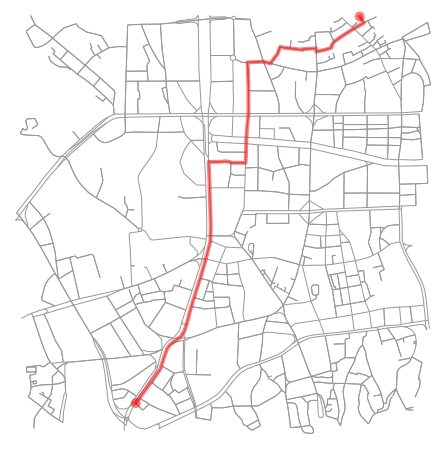

In [250]:
# find the shortest path between these nodes, minimizing travel time, then plot it
route = ox.shortest_path(G3, orig_node, dest_node, weight='travel_time')
fig, ax = ox.plot_graph_route(G3, route, node_size=0, bgcolor='w')

In [252]:
center_node = ox.get_nearest_node(G3, ([37.5655, 126.9779]))  #서울광장 좌표
trip_times = [5, 10, 15] #in minutes
#iso_colors = ['Red', 'blue', 'green']
#node_colors = {}

In [253]:
# make the isochrone polygons 
isochrone_polys1 = []
isochrone_polys2 = []
isochrone_polys3 = []

for trip_time in sorted(trip_times, reverse=True):
    subgraph1 = nx.ego_graph(G3, center_node, radius=trip_time, distance='time')
    node_points1 = [Point((data['x'], data['y'])) for node, data in subgraph1.nodes(data=True)]
    bounding_poly1 = gpd.GeoSeries(node_points1).unary_union.convex_hull
    isochrone_polys1.append(bounding_poly1)

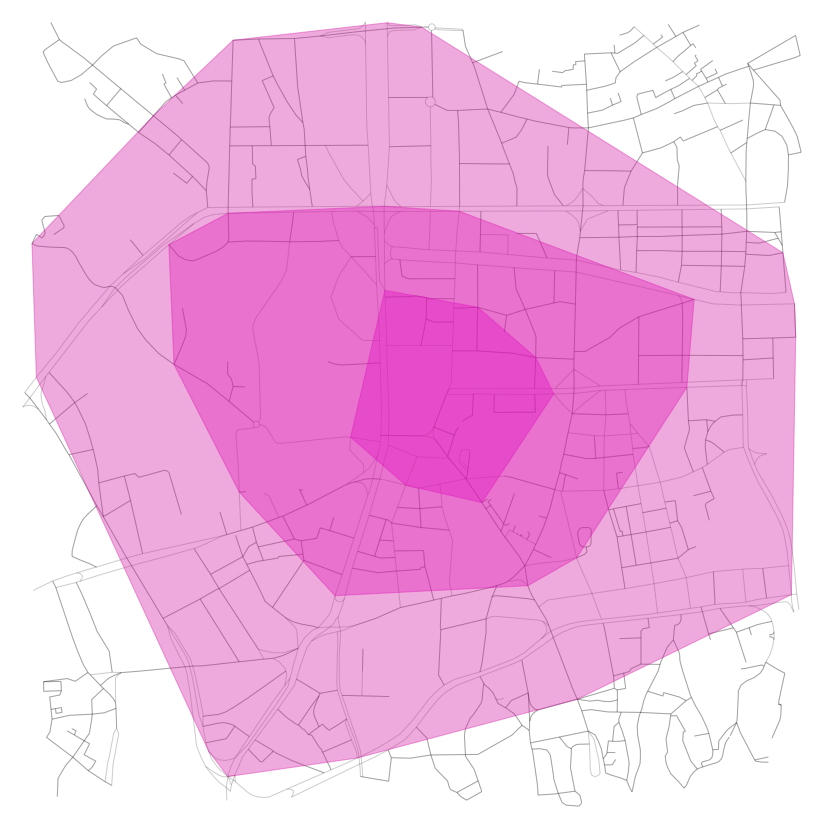

In [254]:
# plot the network then add isochrones as colored descartes polygon patches
fig, ax = ox.plot_graph(G3, figsize=(15,15), edge_color='k', edge_alpha=0.2, node_color='none', bgcolor='white', show=False, close=False)

for polygon1, fc in zip(isochrone_polys1, 'gray'):  
    patch1 = PolygonPatch(polygon1, alpha=0.2, zorder=4, color='magenta')
    ax.add_patch(patch1)

for polygon2, fc in zip(isochrone_polys1, 'gray'):  
    patch2 = PolygonPatch(polygon2, alpha=0.1, zorder=3, color='brown')
    ax.add_patch(patch2)

for polygon3, fc in zip(isochrone_polys1, 'gray'):  
    patch3 = PolygonPatch(polygon3, alpha=0.1, zorder=2, color='brown')
    ax.add_patch(patch3)
   
fig = plt.gcf()
#plt.show()
#plt.savefig("./image/servicearea.png", bbox_inches='tight', pad_inches=0)

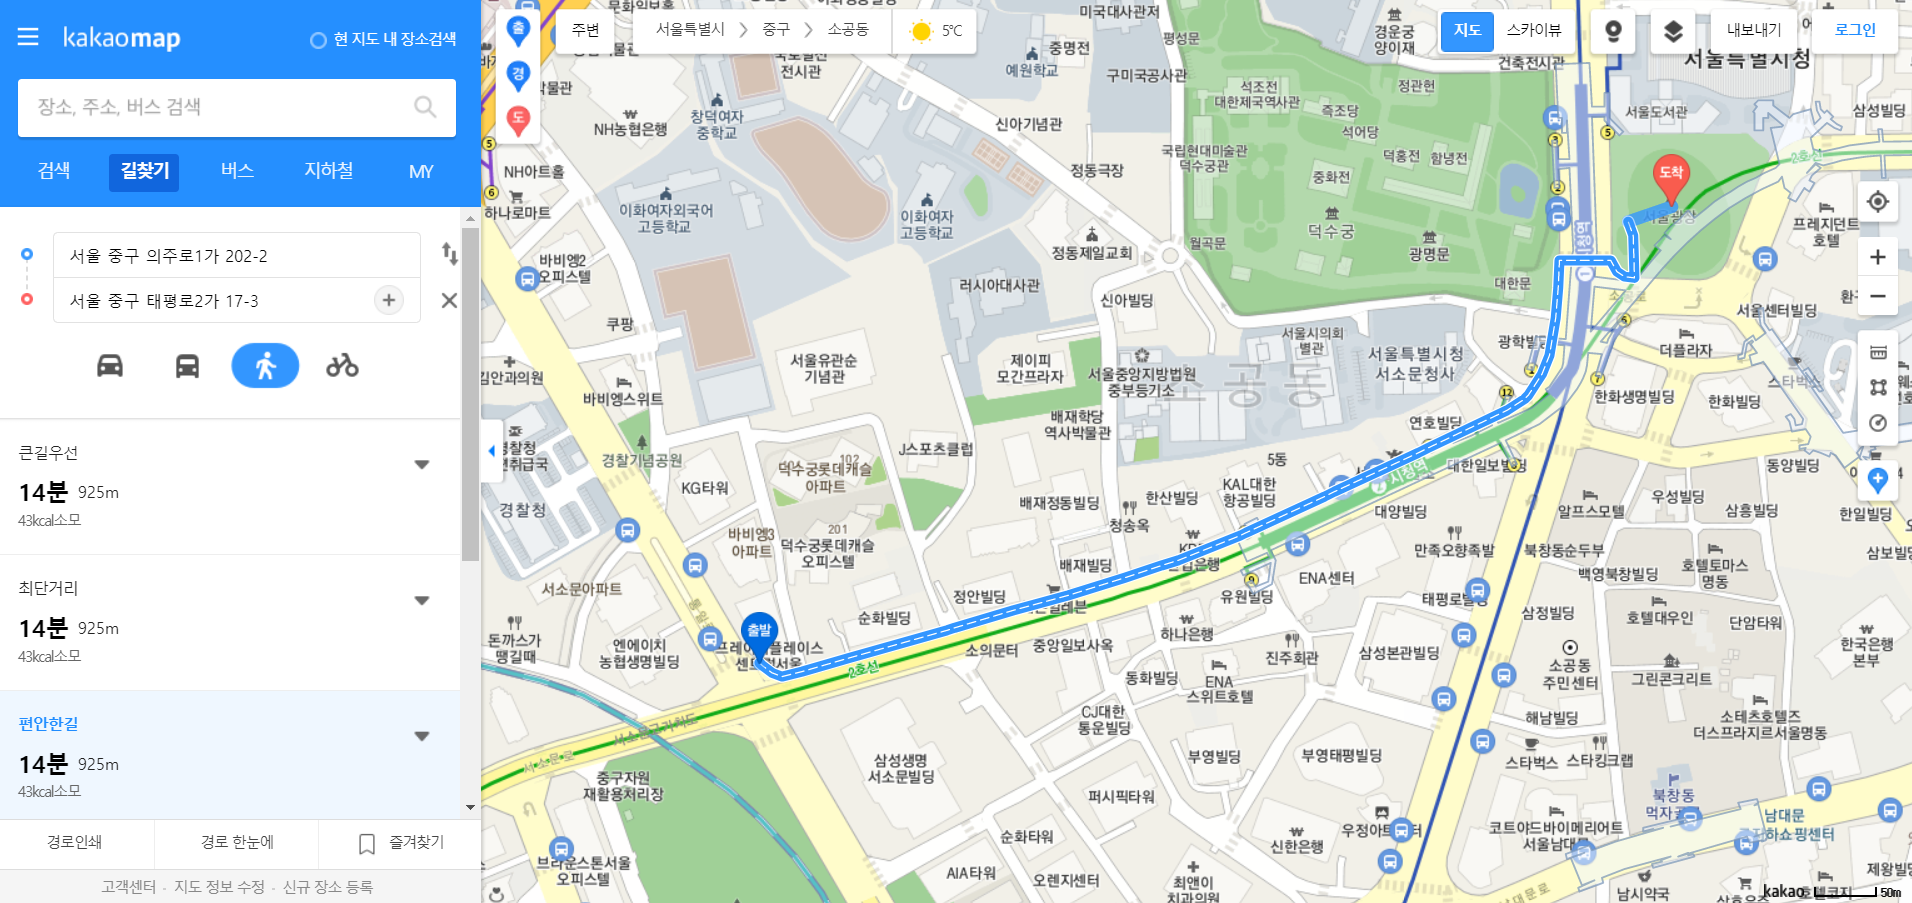

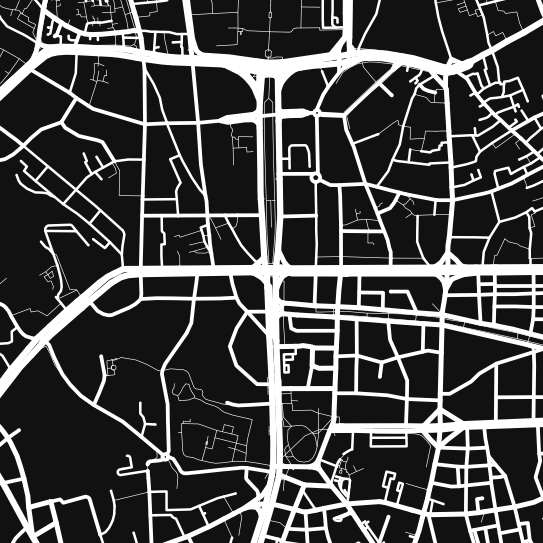

In [155]:
from IPython.display import Image
%matplotlib inline
img_folder = 'image'
place = 'sf'
extension = 'png'
size = 1200
dpi = 90  #해상도를 200 이상으로 올리고 재실행해보세요 

street_widths = {'footway' : 0.5,
                 'steps' : 0.5,
                 'pedestrian' : 0.5,
                 'path' : 0.5,
                 'track' : 0.5,
                 'service' : 2,
                 'residential' : 3,
                 'primary' : 5,
                 'motorway' : 6}

point = (37.570129, 126.976953)
fp = f'./{img_folder}/{place}.{extension}'

fig, ax = ox.plot_figure_ground(point=point, network_type='all', street_widths=street_widths, filepath=fp, dpi=dpi, save=True, show=False, close=True )
Image('{}/{}.{}'.format(img_folder, place, extension), height=size, width=size)

# 수고 많으셨습니다!!!